# Project Outline - Water Quality

- Water Quality Dataset from Kaggle - https://www.kaggle.com/adityakadiwal/water-potability

- Predicting potability based on existing features without potability feature

- Testing our predictions on original database potability feature

- Create a feature that is MORE than binary for potability

In [5]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy.stats as stats



from six             import StringIO
from IPython.display import Image
from ds_models      import ds_models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline                import Pipeline
from sklearn.impute                  import SimpleImputer
from sklearn.preprocessing           import StandardScaler, OneHotEncoder, normalize
from sklearn.model_selection         import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics                 import mean_squared_error, mean_squared_log_error, accuracy_score
from sklearn.metrics                 import plot_confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.tree         import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble     import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble     import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm          import SVC

import warnings
warnings.filterwarnings('ignore')
import pydotplus

# Data Exploration and Cleaning

In [6]:
df = pd.read_csv('water_potability.csv')

### Raw Potability Histogram

(array([1998.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1278.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

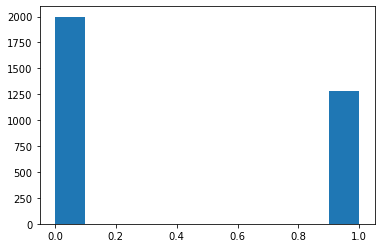

In [7]:
plt.hist(df['Potability'])

### Cleaning NaN values

In [8]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [9]:
df_scrub = df.dropna()
df_scrub.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

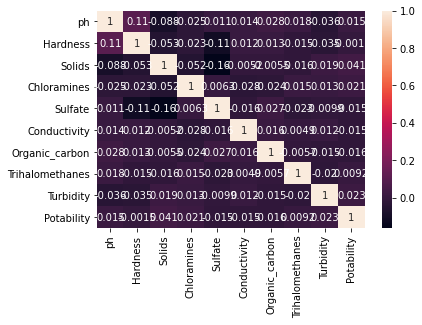

In [10]:
sns.heatmap(df_scrub.corr(), annot=True);

In [11]:
df_scrub.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.108948,-0.087615,-0.024768,0.010524,0.014128,0.028375,0.018278,-0.035849,0.014530
Hardness,0.108948,1.000000,-0.053269,-0.022685,-0.108521,0.011731,0.013224,-0.015400,-0.034831,-0.001505
Solids,-0.087615,-0.053269,1.000000,-0.051789,-0.162769,-0.005198,-0.005484,-0.015668,0.019409,0.040674
Chloramines,-0.024768,-0.022685,-0.051789,1.000000,0.006254,-0.028277,-0.023808,0.014990,0.013137,0.020784
Sulfate,0.010524,-0.108521,-0.162769,0.006254,1.000000,-0.016192,0.026776,-0.023347,-0.009934,-0.015303
Conductivity,0.014128,0.011731,-0.005198,-0.028277,-0.016192,1.000000,0.015647,0.004888,0.012495,-0.015496
Organic_carbon,0.028375,0.013224,-0.005484,-0.023808,0.026776,0.015647,1.000000,-0.005667,-0.015428,-0.015567
Trihalomethanes,0.018278,-0.015400,-0.015668,0.014990,-0.023347,0.004888,-0.005667,1.000000,-0.020497,0.009244
Turbidity,-0.035849,-0.034831,0.019409,0.013137,-0.009934,0.012495,-0.015428,-0.020497,1.000000,0.022682
Potability,0.014530,-0.001505,0.040674,0.020784,-0.015303,-0.015496,-0.015567,0.009244,0.022682,1.000000


In [12]:
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


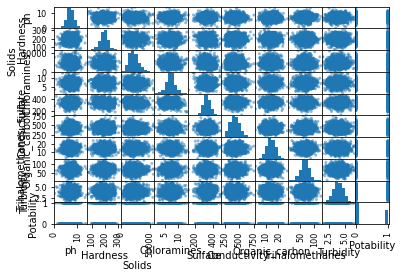

In [13]:
pd.plotting.scatter_matrix(df_scrub);

In [14]:
X = df_scrub.drop(columns=['Potability'], axis=1)

In [15]:
#removing outliers
Q1 = df_scrub.quantile(0.25)
Q3 = df_scrub.quantile(0.75)
IQR = df_scrub.apply(stats.iqr)
df_out = df_scrub[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]
df_out

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3264,5.893103,239.269481,20526.666156,6.349561,341.256362,403.617560,18.963707,63.846319,4.390702,1
3265,8.197353,203.105091,27701.794055,6.472914,328.886838,444.612724,14.250875,62.906205,3.361833,1
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1


In [16]:
df_out.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.136757,-0.083581,-0.057247,0.001629,0.016382,0.014639,0.021370,-0.034367,0.023984
Hardness,0.136757,1.000000,-0.041452,-0.025666,-0.097415,0.020513,0.016443,-0.020773,-0.032161,0.024973
Solids,-0.083581,-0.041452,1.000000,-0.038331,-0.142391,-0.008617,0.006192,-0.022538,0.024278,0.037252
Chloramines,-0.057247,-0.025666,-0.038331,1.000000,0.046301,-0.028477,-0.008113,0.016134,-0.006732,0.018768
Sulfate,0.001629,-0.097415,-0.142391,0.046301,1.000000,-0.006741,0.021000,-0.010572,-0.006415,-0.000253
Conductivity,0.016382,0.020513,-0.008617,-0.028477,-0.006741,1.000000,0.008948,-0.000299,0.012312,-0.014889
Organic_carbon,0.014639,0.016443,0.006192,-0.008113,0.021000,0.008948,1.000000,-0.013545,-0.016440,-0.009076
Trihalomethanes,0.021370,-0.020773,-0.022538,0.016134,-0.010572,-0.000299,-0.013545,1.000000,-0.020006,0.009663
Turbidity,-0.034367,-0.032161,0.024278,-0.006732,-0.006415,0.012312,-0.016440,-0.020006,1.000000,0.029921
Potability,0.023984,0.024973,0.037252,0.018768,-0.000253,-0.014889,-0.009076,0.009663,0.029921,1.000000


### Clean Potability Histogram

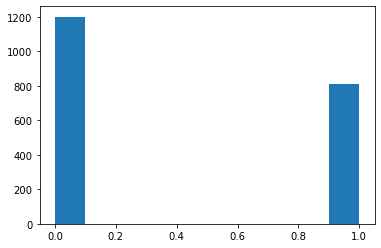

In [30]:
plt.hist(df1['Potability']);

# Data Instantiation

In [7]:
X = df1.drop(columns=['Potability'], axis=1)
y = df1['Potability']

# Model Instantiation

## Gaussian Naive Bayes

In [8]:
#model = GaussianNB()
#model = BaggingClassifier(GaussianNB())
#model = AdaBoostClassifier(GaussianNB())

## KNeighbors Classifier

In [9]:
#model = KNeighborsClassifier()
#knc_grid   = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}
#model      = GridSearchCV(KNeighborsClassifier(), knc_grid, scoring='accuracy', verbose=1)
#model      = AdaBoostClassifier(KNeighborsClassifier())

## Logistic Regression

In [10]:
#model = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs', multi_class='auto')
#logreg_grid = {'C': [1, 2, 3], 'solver': [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]}
#model       = GridSearchCV(LogisticRegression(), logreg_grid, scoring='accuracy', verbose=1)

## Decision Tree Classifier

In [11]:
#model = DecisionTreeClassifier()
#dtc_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
#model    = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

## Bagging Classifier

In [12]:
#model = BaggingClassifier()
#bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
#model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

## Random Forest Classifier

In [13]:
#model = RandomForestClassifier()
#rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
#            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
#model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

## Adaptive Boosting Classifier

In [14]:
#model = AdaBoostClassifier()

## Gradient Boosting Classifier

In [15]:
#model = GradientBoostingClassifier()

## Support Vector Classification

In [16]:
#model = SVC()
#svc_grid = {'C': [1, 2, 3], 'kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]}
#model    = GridSearchCV(SVC(), svc_grid, scoring='accuracy', verbose=1)

# Model Testing 

### Gaussian Naive Bayes - Vanilla

Gaussian Naive Bayes - Vanilla Train Data Confusion Matrix:



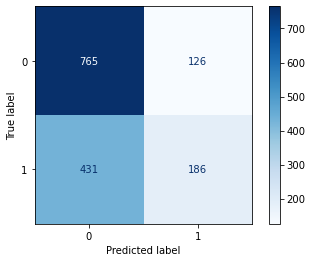

Gaussian Naive Bayes - Vanilla Test Data Confusion Matrix:



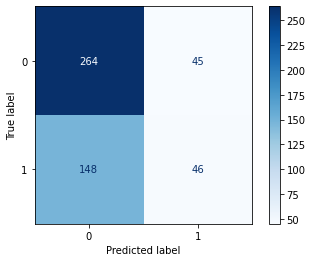

Gaussian Naive Bayes - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       891
           1       0.60      0.30      0.40       617

    accuracy                           0.63      1508
   macro avg       0.62      0.58      0.57      1508
weighted avg       0.62      0.63      0.60      1508

Gaussian Naive Bayes - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       309
           1       0.51      0.24      0.32       194

    accuracy                           0.62       503
   macro avg       0.57      0.55      0.53       503
weighted avg       0.59      0.62      0.57       503



In [17]:
model = GaussianNB()

gnb = ds_models(model, X, y, model_name='Gaussian Naive Bayes - Vanilla', output='class')

### KNeighbors Classifier - Vanilla

KNeighbors Classifier - Vanilla Train Data Confusion Matrix:



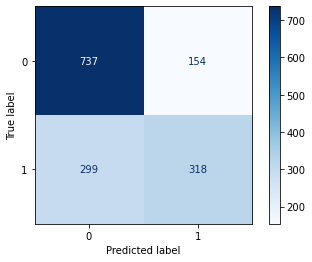

KNeighbors Classifier - Vanilla Test Data Confusion Matrix:



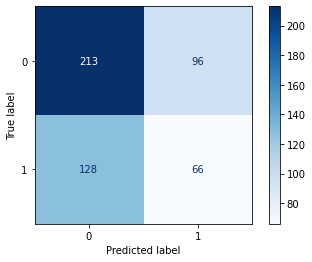

KNeighbors Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       891
           1       0.67      0.52      0.58       617

    accuracy                           0.70      1508
   macro avg       0.69      0.67      0.67      1508
weighted avg       0.70      0.70      0.69      1508

KNeighbors Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       309
           1       0.41      0.34      0.37       194

    accuracy                           0.55       503
   macro avg       0.52      0.51      0.51       503
weighted avg       0.54      0.55      0.55       503



In [18]:
model = KNeighborsClassifier()

knc = ds_models(model, X, y, model_name='KNeighbors Classifier - Vanilla', output='class')

### Logistic Regression - Vanilla

Logistic Regression - Vanilla Train Data Confusion Matrix:



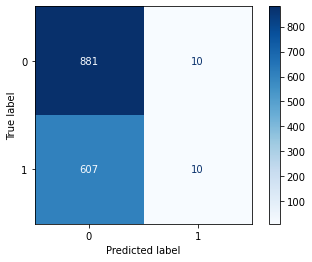

Logistic Regression - Vanilla Test Data Confusion Matrix:



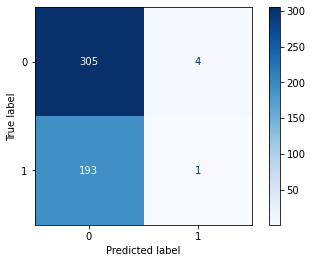

Logistic Regression - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.59      0.99      0.74       891
           1       0.50      0.02      0.03       617

    accuracy                           0.59      1508
   macro avg       0.55      0.50      0.39      1508
weighted avg       0.55      0.59      0.45      1508

Logistic Regression - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.61      0.99      0.76       309
           1       0.20      0.01      0.01       194

    accuracy                           0.61       503
   macro avg       0.41      0.50      0.38       503
weighted avg       0.45      0.61      0.47       503



In [19]:
model = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs', multi_class='auto')

lrc = ds_models(model, X, y, model_name='Logistic Regression - Vanilla', output='class')

### Decision Tree Classifier - Vanilla

Decision Tree Classifier - Vanilla Train Data Confusion Matrix:



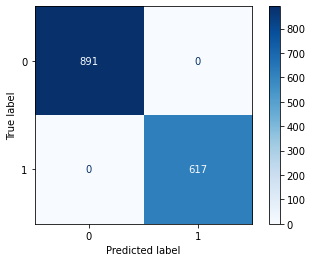

Decision Tree Classifier - Vanilla Test Data Confusion Matrix:



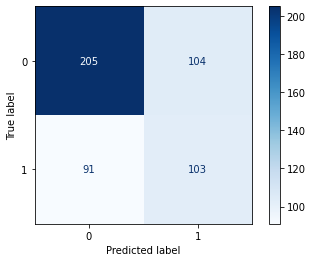

Decision Tree Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Decision Tree Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       309
           1       0.50      0.53      0.51       194

    accuracy                           0.61       503
   macro avg       0.60      0.60      0.60       503
weighted avg       0.62      0.61      0.61       503

Feature Importances:

[0.1674874  0.11529789 0.12559074 0.12370115 0.11048525 0.08086258
 0.10724824 0.09218266 0.07714408]


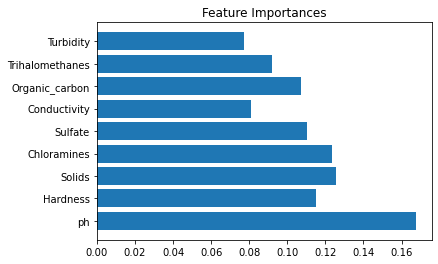

In [20]:
model = DecisionTreeClassifier()

dtc = ds_models(model, X, y, model_name='Decision Tree Classifier - Vanilla', output='class', fi=True)

### Bagging Classifier - Vanilla

Bagging Classifier - Vanilla Train Data Confusion Matrix:



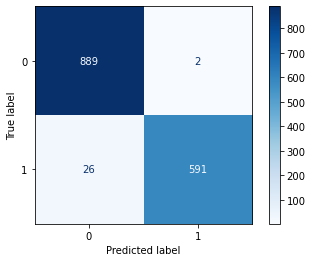

Bagging Classifier - Vanilla Test Data Confusion Matrix:



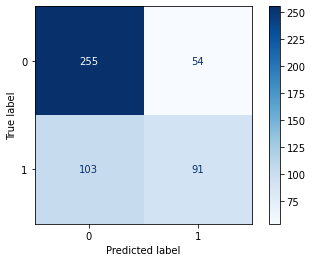

Bagging Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       891
           1       1.00      0.96      0.98       617

    accuracy                           0.98      1508
   macro avg       0.98      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       309
           1       0.63      0.47      0.54       194

    accuracy                           0.69       503
   macro avg       0.67      0.65      0.65       503
weighted avg       0.68      0.69      0.68       503



In [21]:
model = BaggingClassifier()

bc = ds_models(model, X, y, model_name='Bagging Classifier - Vanilla', output='class')

### Random Forest Classifier - Vanilla

Randmon Forest Classifier - Vanilla Train Data Confusion Matrix:



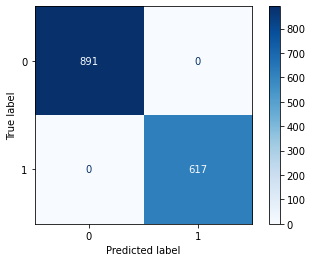

Randmon Forest Classifier - Vanilla Test Data Confusion Matrix:



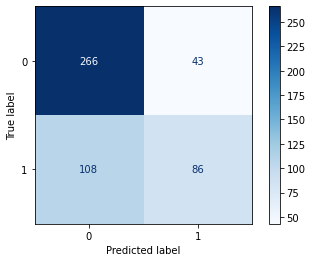

Randmon Forest Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Randmon Forest Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.71      0.86      0.78       309
           1       0.67      0.44      0.53       194

    accuracy                           0.70       503
   macro avg       0.69      0.65      0.66       503
weighted avg       0.69      0.70      0.68       503

Feature Importances:

[0.13623504 0.11409592 0.10910354 0.11668264 0.14615119 0.09605684
 0.09409388 0.09340178 0.09417917]


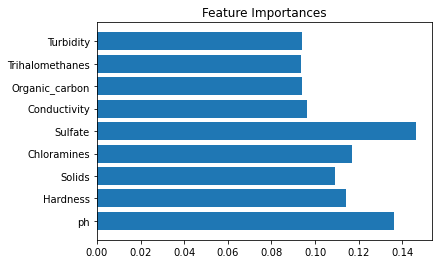

In [22]:
model = RandomForestClassifier()

rfc = ds_models(model, X, y, model_name='Randmon Forest Classifier - Vanilla', output='class', fi=True)

### Adaptive Boosting Classifier - Vanilla

Adaptive Boosting Classifier - Vanilla Train Data Confusion Matrix:



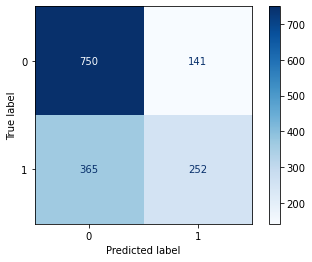

Adaptive Boosting Classifier - Vanilla Test Data Confusion Matrix:



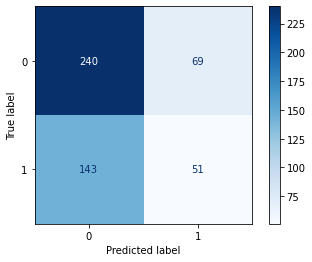

Adaptive Boosting Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.67      0.84      0.75       891
           1       0.64      0.41      0.50       617

    accuracy                           0.66      1508
   macro avg       0.66      0.63      0.62      1508
weighted avg       0.66      0.66      0.65      1508

Adaptive Boosting Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.63      0.78      0.69       309
           1       0.42      0.26      0.32       194

    accuracy                           0.58       503
   macro avg       0.53      0.52      0.51       503
weighted avg       0.55      0.58      0.55       503

Feature Importances:

[0.18 0.16 0.04 0.1  0.12 0.02 0.16 0.12 0.1 ]


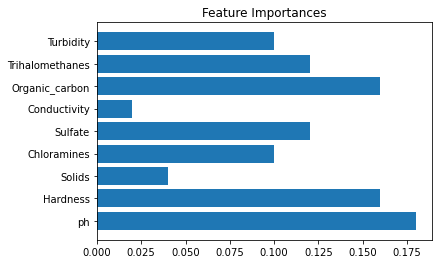

In [23]:
model = AdaBoostClassifier()

abc = ds_models(model, X, y, model_name='Adaptive Boosting Classifier - Vanilla', output='class', fi=True)

### Gradient Boosting Classifier - Vanilla

Gradient Boosting Classifier - Vanilla Train Data Confusion Matrix:



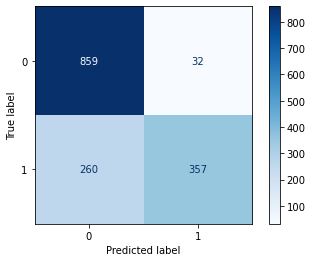

Gradient Boosting Classifier - Vanilla Test Data Confusion Matrix:



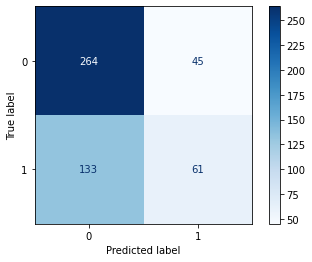

Gradient Boosting Classifier - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       891
           1       0.92      0.58      0.71       617

    accuracy                           0.81      1508
   macro avg       0.84      0.77      0.78      1508
weighted avg       0.83      0.81      0.80      1508

Gradient Boosting Classifier - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.66      0.85      0.75       309
           1       0.58      0.31      0.41       194

    accuracy                           0.65       503
   macro avg       0.62      0.58      0.58       503
weighted avg       0.63      0.65      0.62       503

Feature Importances:

[0.2543916  0.10694568 0.07898586 0.11535993 0.20126103 0.04345271
 0.07413439 0.06657619 0.05889261]


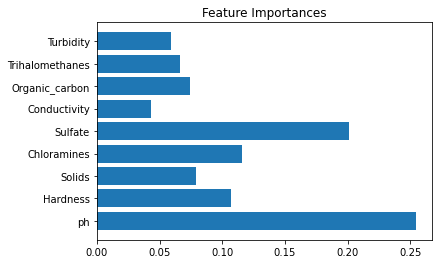

In [24]:
model = GradientBoostingClassifier()

gbc = ds_models(model, X, y, model_name='Gradient Boosting Classifier - Vanilla', output='class', fi=True)

### Support Vector Classification - Vanilla

Support Vector Classification - Vanilla Train Data Confusion Matrix:



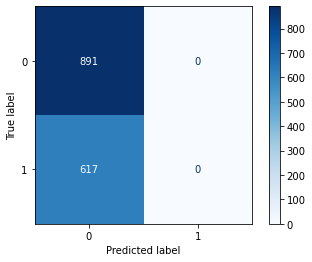

Support Vector Classification - Vanilla Test Data Confusion Matrix:



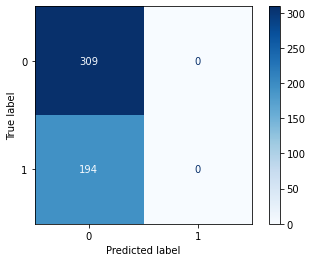

Support Vector Classification - Vanilla Train Report:

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       891
           1       0.00      0.00      0.00       617

    accuracy                           0.59      1508
   macro avg       0.30      0.50      0.37      1508
weighted avg       0.35      0.59      0.44      1508

Support Vector Classification - Vanilla Test Report:

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       309
           1       0.00      0.00      0.00       194

    accuracy                           0.61       503
   macro avg       0.31      0.50      0.38       503
weighted avg       0.38      0.61      0.47       503



In [25]:
model = SVC()

svc = ds_models(model, X, y, model_name='Support Vector Classification - Vanilla', output='class')